In [1]:
from distributions.spiral import sample_spiral_distribution
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from triangular.triangular import TriangularTransport, triangular_transport_loss, separable_triangular_loss
import yaml
from types import SimpleNamespace
import matplotlib.pyplot as plt
from matplotlib import cm
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

def dict_to_namespace(d):
    def convert_value(v):
        if isinstance(v, dict):
            return dict_to_namespace(v)
        if isinstance(v, str):
            try:
                return float(v)
            except ValueError:
                return v  # leave as string if it can't be converted
        return v
    return SimpleNamespace(**{k: convert_value(v) for k, v in d.items()})

with open("configs.yaml") as f:
    config = yaml.safe_load(f)
config = dict_to_namespace(config)

In [2]:
config = config.triangular
config

namespace(input_dim=2,
          hidden_dim=32,
          hidden_layers=4,
          device='cuda',
          weight_decay=0,
          batch_size=128,
          epochs=100,
          learning_rate=0.0005)

In [3]:
X = sample_spiral_distribution(10000)
X = torch.tensor(X, dtype=torch.float32)
# Normalize (standardization)
mean = X.mean(dim=0)
std = X.std(dim=0)
X_norm = (X - mean) / std

# Wrap in dataset
dataset = TensorDataset(X_norm)
loader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True)
model = TriangularTransport(config).to(config.device)

In [4]:
for epoch in range(config.epochs):
    epoch_losses = 0.0
    count = 0

    for batch in loader:
        x = batch[0].to(config.device).clone().detach().requires_grad_(True)
        loss = separable_triangular_loss(model, x)
        model.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        model.optimizer.step()
        epoch_losses += loss.item()
        count += 1
    if (epoch + 1) % 2 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}: Loss = {epoch_losses/count:.4f}")

Epoch 1: Loss = 1.3113
Epoch 2: Loss = 1.0015
Epoch 4: Loss = 0.2686
Epoch 6: Loss = 0.0754
Epoch 8: Loss = 0.0326
Epoch 10: Loss = -0.0035
Epoch 12: Loss = -0.0211
Epoch 14: Loss = -0.0407
Epoch 16: Loss = -0.0718
Epoch 18: Loss = -0.1176
Epoch 20: Loss = -0.1591
Epoch 22: Loss = -0.1916
Epoch 24: Loss = -0.2058
Epoch 26: Loss = -0.2322
Epoch 28: Loss = -0.2420
Epoch 30: Loss = -0.2599
Epoch 32: Loss = -0.2767
Epoch 34: Loss = -0.2887
Epoch 36: Loss = -0.3012
Epoch 38: Loss = -0.3116
Epoch 40: Loss = -0.3292
Epoch 42: Loss = -0.3354
Epoch 44: Loss = -0.3379
Epoch 46: Loss = -0.3380
Epoch 48: Loss = -0.3564
Epoch 50: Loss = -0.3551
Epoch 52: Loss = -0.3626
Epoch 54: Loss = -0.3695
Epoch 56: Loss = -0.3664
Epoch 58: Loss = -0.3723
Epoch 60: Loss = -0.3794
Epoch 62: Loss = -0.3769
Epoch 64: Loss = -0.3807
Epoch 66: Loss = -0.3857
Epoch 68: Loss = -0.3876
Epoch 70: Loss = -0.3932
Epoch 72: Loss = -0.3927
Epoch 74: Loss = -0.3935
Epoch 76: Loss = -0.3990
Epoch 78: Loss = -0.3925
Epoch 80: 

In [5]:
x = torch.randn(5, 2).to(config.device)  # Example input
z = model(x)              # Forward
x_inv = model.inverse(z)  # Inverse
print(torch.max(torch.abs(x - x_inv)))  # should be close to 0
print("x", x)
print("z", z)
print("x_inv", x_inv)
print("z - x", x - x_inv)

tensor(0.0926, device='cuda:0', grad_fn=<MaxBackward1>)
x tensor([[-0.4340, -0.8728],
        [ 0.2681,  0.6010],
        [-0.0319, -1.0490],
        [-0.7888,  0.7255],
        [-0.5624, -1.4634]], device='cuda:0')
z tensor([[-0.2652, -0.4055],
        [ 0.1613, -0.4708],
        [-0.0192, -0.4711],
        [-0.5133,  0.3183],
        [-0.3485, -0.3684]], device='cuda:0', grad_fn=<CopySlices>)
x_inv tensor([[-0.4340, -0.8240],
        [ 0.2681,  0.6010],
        [-0.0319, -1.1416],
        [-0.7888,  0.7255],
        [-0.5624, -1.4634]], device='cuda:0', grad_fn=<CopySlices>)
z - x tensor([[ 2.9802e-08, -4.8789e-02],
        [ 0.0000e+00, -2.6226e-06],
        [ 0.0000e+00,  9.2608e-02],
        [ 2.3842e-07,  2.3842e-07],
        [-5.9605e-08, -3.0994e-06]], device='cuda:0', grad_fn=<SubBackward0>)


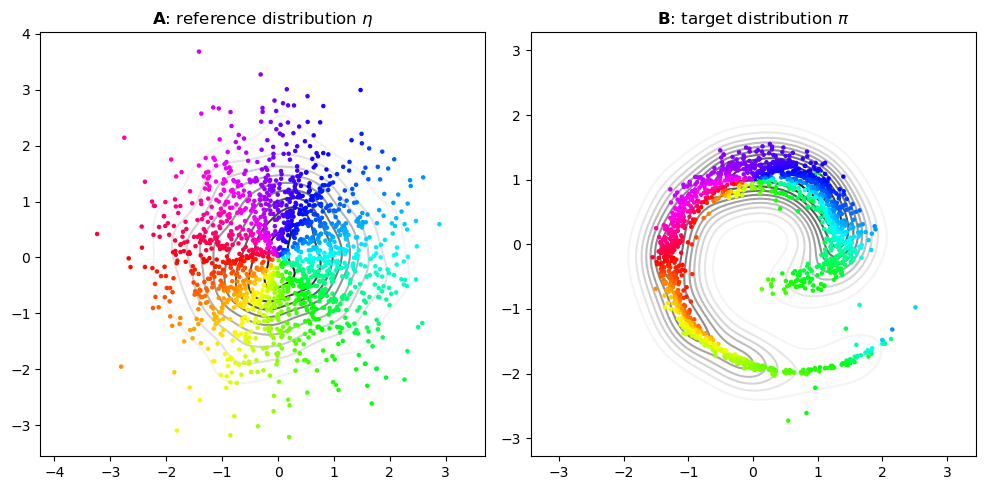

In [8]:
from sklearn.neighbors import KernelDensity
# Helper to compute KDE for contours
def get_kde_contour(samples, bounds=(-6, 6), n=100, bandwidth=0.1):
    x_grid = np.linspace(bounds[0], bounds[1], n)
    y_grid = np.linspace(bounds[0], bounds[1], n)
    xx, yy = np.meshgrid(x_grid, y_grid)
    xy = np.stack([xx.ravel(), yy.ravel()], axis=1)
    kde = KernelDensity(bandwidth=bandwidth).fit(samples)
    zz = np.exp(kde.score_samples(xy)).reshape(xx.shape)
    return xx, yy, zz

# 5. Visualize samples from the trained flow
x,z = model.sample(1500)
x = x.detach().cpu().numpy()
z = z.detach().cpu().numpy()
colors = cm.hsv((np.arctan2(z[:, 1], z[:, 0]) + np.pi) / (2 * np.pi))  # color by angle


# Compute KDE contours for reference and target
xx_z, yy_z, zz_z = get_kde_contour(z, bounds=(-3, 3), bandwidth=0.3)
xx_x, yy_x, zz_x = get_kde_contour(x, bounds=(-3, 3), bandwidth=0.3)

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# Reference (z)
axes[0].contour(xx_z, yy_z, zz_z, levels=10, cmap='Greys')
axes[0].scatter(z[:, 0], z[:, 1], c=colors, s=5, zorder=10)
axes[0].set_title(r"$\bf{A}$: reference distribution $\eta$")
axes[0].axis("equal")
# axes[0].tick_params(
#     left=False, right=False,  # no y ticks
#     bottom=False, top=False,  # no x ticks
#     labelleft=False, labelbottom=False  # no labels
# )


# Target (x)
axes[1].contour(xx_x, yy_x, zz_x, levels=10, cmap='Greys')
axes[1].scatter(x[:, 0], x[:, 1], c=colors, s=5, zorder=10)
axes[1].set_title(r"$\bf{B}$: target distribution $\pi$")
axes[1].axis("equal")
# axes[1].set_xlim(-3, 3)
# axes[1].set_ylim(-3, 3)
# axes[1].tick_params(
#     left=False, right=False,  # no y ticks
#     bottom=False, top=False,  # no x ticks
#     labelleft=False, labelbottom=False  # no labels
# )



plt.tight_layout()
plt.show()